In [1]:
from sklearn import svm # for Discriminator
from sklearn.model_selection import train_test_split # for train-test split 
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.model_selection import GridSearchCV # for fine-tuning
from sklearn.metrics import make_scorer, balanced_accuracy_score # for evaluation
from sklearn.pipeline import make_pipeline # for prediction

In [2]:
# for Generator
from scipy import stats # for sampling
from fitter import Fitter # for fitting the best distribution
import copy # for copying nested dictionaries

In [3]:
import matplotlib.pyplot as plt  # for visualization 
import seaborn as sns  # for coloring 

# set style of graphs
plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [4]:
import pandas as pd

In [5]:
import numpy as np

In [6]:
df = pd.read_csv("games.csv")
df.head() 

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-03-12,22101005,Final,1610612748,1610612750,2021,1610612748,104.0,0.398,0.760,...,23.0,53.0,1610612750,113.0,0.422,0.875,0.357,21.0,46.0,0
1,2022-03-12,22101006,Final,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,...,20.0,46.0,1610612739,91.0,0.419,0.824,0.208,19.0,40.0,1
2,2022-03-12,22101007,Final,1610612759,1610612754,2021,1610612759,108.0,0.412,0.813,...,28.0,52.0,1610612754,119.0,0.489,1.000,0.389,23.0,47.0,0
3,2022-03-12,22101008,Final,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,...,33.0,55.0,1610612749,109.0,0.413,0.696,0.386,27.0,39.0,1
4,2022-03-12,22101009,Final,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,...,32.0,39.0,1610612761,127.0,0.471,0.760,0.387,28.0,50.0,0


## Predicting NBA playoff results with simulation

### Background:
NBA playoff is a best-of-seven elimination tournament.

There are 16 competing teams; 8 initial pairs.

Each pair will play up-to 7 games, so it takes 4 games to win.

A total of 4 rounds are required to win the championship 🏆.

### Our Goal:
Our goal is to predict the probability of winning for each team and at each round of the playoff, in order to see who may win the championship.

### Workflow:
Data cleaning

Fit a win/loss Discriminator(D)

Fit a feature Generator(G)

Run n_simulations with both D and G according to the rules of playoff

Visualization

### 1. Data Cleaning

In [7]:
df = pd.read_csv("games.csv")
df.head() 

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-03-12,22101005,Final,1610612748,1610612750,2021,1610612748,104.0,0.398,0.760,...,23.0,53.0,1610612750,113.0,0.422,0.875,0.357,21.0,46.0,0
1,2022-03-12,22101006,Final,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,...,20.0,46.0,1610612739,91.0,0.419,0.824,0.208,19.0,40.0,1
2,2022-03-12,22101007,Final,1610612759,1610612754,2021,1610612759,108.0,0.412,0.813,...,28.0,52.0,1610612754,119.0,0.489,1.000,0.389,23.0,47.0,0
3,2022-03-12,22101008,Final,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,...,33.0,55.0,1610612749,109.0,0.413,0.696,0.386,27.0,39.0,1
4,2022-03-12,22101009,Final,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,...,32.0,39.0,1610612761,127.0,0.471,0.760,0.387,28.0,50.0,0


In [8]:
# sort dataframe by date
df = df.sort_values(by='GAME_DATE_EST').reset_index(drop = True)
# drop empty entries, data before 2004 contains NaN
df = df.loc[df['GAME_DATE_EST'] >= "2004-01-01"].reset_index(drop=True)
# check null
df.isnull().values.any() 

False

In [9]:
# replace Team ID with Names
df_names = pd.read_csv('teams.csv')
df_names.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [10]:
# We have two columns to replace, there are 'HOME_TEAM_ID' and 'VISITOR_TEAM_ID'

df_names = df_names[['TEAM_ID', 'NICKNAME']]

# replace 'HOME_TEAM_ID' with names in df_names
home_names = df_names.copy() # copy the names data
home_names.columns = ['HOME_TEAM_ID', 'NICKNAME'] # change the column names before merging
# merge names according to df on "ID"
result_1 = pd.merge(df['HOME_TEAM_ID'], home_names, how ="left", on="HOME_TEAM_ID")  
df['HOME_TEAM_ID'] = result_1['NICKNAME']

# replace 'VISITOR_TEAM_ID' with names in df_names
visitor_names = df_names.copy() # copy the names data
visitor_names.columns = ['VISITOR_TEAM_ID', 'NICKNAME'] # change the column names before merging
# merge names according to df on "ID"
result_2 = pd.merge(df['VISITOR_TEAM_ID'], visitor_names, how = "left", on="VISITOR_TEAM_ID")
df['VISITOR_TEAM_ID'] = result_2['NICKNAME']

In [11]:
# final dataframe
df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2004-01-02,20300458,Final,Timberwolves,Hawks,2003,1610612750,93.0,0.409,0.929,...,32.0,56.0,1610612737,75.0,0.372,0.737,0.375,22.0,31.0,1
1,2004-01-02,20300451,Final,Wizards,Warriors,2003,1610612764,97.0,0.446,0.611,...,30.0,58.0,1610612744,79.0,0.403,0.818,0.381,20.0,36.0,1
2,2004-01-02,20300454,Final,Knicks,Bulls,2003,1610612752,99.0,0.470,0.800,...,25.0,38.0,1610612741,104.0,0.488,0.724,0.385,20.0,44.0,0
3,2004-01-02,20300457,Final,Pistons,Suns,2003,1610612765,93.0,0.389,0.947,...,26.0,54.0,1610612756,81.0,0.395,0.895,0.364,20.0,34.0,1
4,2004-01-02,20300456,Final,Heat,Magic,2003,1610612748,112.0,0.466,0.792,...,29.0,42.0,1610612753,101.0,0.430,0.750,0.450,15.0,37.0,1


### 2. Fitting an SVM win/loss discriminator


In [12]:
# we want to try and predict the 2019-2020 NBA play off results starting 2020-08 >
# hence, this portion of the data is held out
df = df.loc[df['GAME_DATE_EST'] < '2021-08-01'].reset_index(drop=True)

In [13]:
feature_list = list(df.columns)
feature_list

['GAME_DATE_EST',
 'GAME_ID',
 'GAME_STATUS_TEXT',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'TEAM_ID_home',
 'PTS_home',
 'FG_PCT_home',
 'FT_PCT_home',
 'FG3_PCT_home',
 'AST_home',
 'REB_home',
 'TEAM_ID_away',
 'PTS_away',
 'FG_PCT_away',
 'FT_PCT_away',
 'FG3_PCT_away',
 'AST_away',
 'REB_away',
 'HOME_TEAM_WINS']

In [14]:
# To predict win/loss of a game, we can use one of the two ways:

#1. Select only one feature (points), the win/loss prediction is just based on which team has the higher point.
#2. Select features other than points, the win/loss is then based on the prediction of a classifier which takes those features as inputs.

# In this notebook, we will use option (2) as it offers better range of uncertainty for simulation.

selected_features = [
    'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
    'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
    ]

# check the features we selected
X = df[selected_features]
X.head()

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away
0,0.409,0.929,0.308,32.0,56.0,0.372,0.737,0.375,22.0,31.0
1,0.446,0.611,0.400,30.0,58.0,0.403,0.818,0.381,20.0,36.0
2,0.470,0.800,0.333,25.0,38.0,0.488,0.724,0.385,20.0,44.0
3,0.389,0.947,0.238,26.0,54.0,0.395,0.895,0.364,20.0,34.0
4,0.466,0.792,0.500,29.0,42.0,0.430,0.750,0.450,15.0,37.0


In [15]:
# check the targets
y = df['HOME_TEAM_WINS']
y.head()

0    1
1    1
2    0
3    1
4    1
Name: HOME_TEAM_WINS, dtype: int64

In [16]:
# turn them into numpy arrays for training

X = X.to_numpy()
y = y.to_numpy()

In [17]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, random_state=42)

print("X shape", X_train.shape, "y shape", y_train.shape)

X shape (16909, 10) y shape (16909,)


### Fitting SVM¶


In [18]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3, random_state=42)

print("X shape", X_train.shape, "y shape", y_train.shape)

X shape (16909, 10) y shape (16909,)


In [19]:
# feature scaling

scaler = StandardScaler() # initialize an instance 
X_train = scaler.fit_transform(X_train) 

In [20]:
%%time 

# train SVM

clf = svm.SVC(kernel='linear') # initialize a model
clf.fit(X_train, y_train) # fit(train) it with the training data and targets

# check test score 
y_pred = clf.predict(X_test) 
print('balanced accuracy score:', balanced_accuracy_score(y_test, y_pred)) 

balanced accuracy score: 0.69604838880882
CPU times: user 7.84 s, sys: 583 ms, total: 8.43 s
Wall time: 8.9 s


In [21]:
%%time 

# fine-tuning hyperparameters

scoring = make_scorer(balanced_accuracy_score)
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1,0.1,0.01]} #

grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid, scoring = scoring, refit=True, verbose=2) 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................................C=0.1, gamma=1; total time=   4.1s
[CV] END .....................................C=0.1, gamma=1; total time=   4.1s
[CV] END .....................................C=0.1, gamma=1; total time=   4.0s
[CV] END .....................................C=0.1, gamma=1; total time=   4.1s
[CV] END .....................................C=0.1, gamma=1; total time=   4.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   4.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   4.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   4.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   4.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   4.4s
[CV] END ..................................C=0.1, gamma=0.01; total time=   4.1s
[CV] END ..................................C=0.1,

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
             scoring=make_scorer(balanced_accuracy_score), verbose=2)

In [22]:
# print the best model's hyperparameters
Dis = grid.best_estimator_
print(Dis)

SVC(C=10, gamma=1, kernel='linear')


### 3. Fitting a Generator¶

In [23]:
# Like before, we had held out data from 2019-2020 playoff for real testing
# Though large data is essential for fitting, for time-series problems, we give priority to the recent data most reflective of team's recent ability.
# Since we aim to predict 2019-2020 playoff, here we will just fit the data from that regular session which starts in Oct, 2019.

df_ = df.loc[df['GAME_DATE_EST'] > '2020-10-01'].reset_index(drop=True)
df_.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2019-10-04,11900003,Final,Kings,Pacers,2019,1610612758,131.0,0.494,0.778,...,30.0,30.0,1610612754,132.0,0.516,0.788,0.370,26.0,47.0,0
1,2019-10-04,11900002,Final,Clippers,Rockets,2019,1610612746,96.0,0.384,0.600,...,26.0,49.0,1610612745,109.0,0.375,0.800,0.229,21.0,52.0,0
2,2019-10-05,11900006,Final,Warriors,Lakers,2019,1610612744,101.0,0.393,0.769,...,20.0,47.0,1610612747,123.0,0.475,0.633,0.303,32.0,58.0,0
3,2019-10-05,11900007,Final,Spurs,Magic,2019,1610612759,89.0,0.388,0.750,...,22.0,40.0,1610612753,125.0,0.526,0.714,0.361,29.0,47.0,0
4,2019-10-05,11900005,Final,Pacers,Kings,2019,1610612754,130.0,0.521,0.944,...,35.0,51.0,1610612758,106.0,0.378,0.780,0.353,24.0,35.0,1


In [24]:
# here we define the list of common distributions for fitting
# use more distributions with fewer data points, because the distribution will be less "normal"

selected_distributions = [
    'norm','t', 'f', 'chi', 'cosine', 'alpha', 
    'beta', 'gamma', 'dgamma', 'dweibull',
    'maxwell', 'pareto', 'fisk']

In [25]:
unique_teams = df['HOME_TEAM_ID'].unique() # extract all the unique teams

# Since we don't care about whether the team was a host or visitor in each game, 
# we can just combine the features for all games.

# Get all the data for teams
all_team_sim_data = {}

for team_name in unique_teams:
    
    # find games where the team is either the host or guest
    df_team = df_.loc[(df_['HOME_TEAM_ID'] == team_name) | (df_['VISITOR_TEAM_ID'] == team_name)]
    # it is home team, select the first 5 features
    df_1 = df_team.loc[df_team['HOME_TEAM_ID'] == team_name][selected_features[:5]]
    # it is guest team, select the first 5 features
    df_0 = df_team.loc[df_team['VISITOR_TEAM_ID'] == team_name][selected_features[5:]]

    # combine them
    df_0.columns = df_1.columns # before concating, match the column names
    df_s = pd.concat([df_1, df_0], axis = 0)
    
    # convert the pandas.DataFrame to numpy array
    all_team_sim_data[team_name] = df_s.to_numpy()

In [26]:
%%time

# data format:
#   team_name => list of feature distributions => distionary with distribution name and parameters
#   e.g.,
#   megadata = {
      #'Timberwolves': [{'beta': (0.23, 0.3, 0.3, 0.4)}, {'nor': (0.23, 0.3,)}, ..], 
      #'Warriors':[{}, {},...]
      #  }
    
megadata = {} # store the data that our Generator will rely on
for team_name in unique_teams:
    
    feature_dis_paras = []
    data = all_team_sim_data[team_name]
    
    # 5 features for each team
    for i in range(5): 
        f = Fitter(data[:, i]) # initalize a Fitter instance
        f.distributions = selected_distributions # use only the selected distributions (faster)
        f.fit() # do the fitting 
        best_paras = f.get_best(method='sumsquare_error') # get the best fitted paras
        feature_dis_paras.append(best_paras)
        
    megadata[team_name] = feature_dis_paras
    
print('Features for all teams have been fitted!')

Fitting 13 distributions: 100%|█████████████████| 13/13 [00:00<00:00, 24.58it/s]


Fitting 13 distributions: 100%|█████████████████| 13/13 [00:00<00:00, 32.06it/s]

Features for all teams have been fitted!
CPU times: user 1min 11s, sys: 12.7 s, total: 1min 23s
Wall time: 1min 20s


### 4. Simulation¶

In [27]:
DATA = megadata.copy() # data that Generator must rely on

GEN = {
 'alpha': stats.alpha.rvs,
 'beta': stats.beta.rvs,
 'chi': stats.chi.rvs,
 'cosine': stats.cosine.rvs,
 'dgamma': stats.dgamma.rvs,
 'dweibull':stats.dweibull.rvs,
 'f':stats.f.rvs,
 'fisk':stats.fisk.rvs,
 'gamma': stats.gamma.rvs,
 'maxwell':stats.maxwell.rvs,
 'norm':stats.norm.rvs,
 'pareto':stats.pareto.rvs,
 't':stats.t.rvs,
}

In [28]:
# feature scaler + fine-turned SVM 
DIS = make_pipeline(scaler, Dis)

In [29]:
class Game:
    
    '''
    
    A game between two teams:
    
    - feature values sampled from Generator
    - win/loss predicted by Discriminator
    
    '''
    
    def __init__ (self, random_state = None):
        
        self.random_state = random_state # keep this to None for making simulations 
    
    def predict(self, team1, team2, num_games = 1):
        
        ''' predict the win or loss of  n game(s) played by two tems'''
        
        assert num_games >= 1, "at least one game must be played"
        # output numpy array
        team_1_feature_data = DATA[team1]
        team_2_feature_data = DATA[team2]
        features = []
        for feature_paras_1 in team_1_feature_data:
            sample_1 = self.sampling(feature_paras_1, size = num_games) # gives a list if num_games> 1
            features.append(sample_1) 
            
        for feature_paras_2 in team_2_feature_data:
            sample_2 = self.sampling(feature_paras_2, size = num_games) # gives a list if num_games> 1
            features.append(sample_2)
            
        features = np.array(features).T 
        win_loss = DIS.predict(features)
        
        return list(win_loss) # a list of win/loss from num_games
    
    
    def sampling(self, dic, size = 1, random_state = None):
        
        '''generate feature values used for making win/loss prediction'''
                        
        dis_name = list(dic.keys())[0] # get the type
        paras = list(dic.values())[0] # get the paras
    
        # get sample
        sample = GEN[dis_name](**paras, size = size, random_state = random_state)
            
        return sample 

In [30]:
class FinalTournament(Game):
    
    ''' Best-of-7 elimination, 16 teams, 4 rounds in total to win championship '''
    
    def __init__(self, n_games_per_group = 7, winning_threshold = 4, random_state = None):

        self.n_games_per_group  = n_games_per_group
        self.winning_threshold = winning_threshold
        self.team_list = None
        self.rounds = {} # keep track the number of times a team wins at each round 
        super().__init__(random_state)
        
    
    def simulate(self, group_list, n_simulation = 1, probs = True):
        
        ''' simulate the entire playoff n times and also record the accumulated wins'''
             
        # update the list of teams
        self.rounds = {}
        self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        
        for i in range(n_simulation):
            cham = self.one_time_simu(group_list)
        if probs:
            self.rounds_probs =  self._compute_probs()
            
    
    def one_time_simu(self, group_list, verbose = False, probs = False):
        
        ''' simulate the entire playoff once and also record the accumulated wins'''
        
        # update the list of teams if haven't done so
        if self.team_list == None: 
            self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        round_number, done = 0, 0
        while not done: 
            all_group_winners, group_list = self.play_round(group_list)
            # retrive round stats
            try:
                updated_round_stats = self.rounds[round_number]
            except KeyError:
                updated_round_stats = {}
                for team in self.team_list:
                    updated_round_stats[team] = 0
            # if a team wins, record + 1 
            for winner in all_group_winners:
                try: 
                    updated_round_stats[winner] += 1
                except KeyError:
                    pass     
            self.rounds[round_number] = updated_round_stats
            if verbose:
                print('{} round played'.format(round_number))
            if probs:
                self.rounds_probs = self._compute_probs()
            if type(group_list) != list: # if it becomes the final
                done = 1
            round_number += 1
            
        return group_list

        
    def play_round(self, group_list):
        
        '''play a round of games based of a list of paired teams'''
        
        all_group_winners = [] 
        # play each group and get the group winner
        for group in group_list:
            winner = self.play_n_games(group[0], group[1])
            all_group_winners.append(winner)
        
        if len(all_group_winners) > 1:
            new_group_list = []         
            for index in range(0, len(all_group_winners), 2):
                # first winner, second winner
                new_group = [all_group_winners[index], all_group_winners[index + 1]]
                new_group_list.append(new_group)
                
            return all_group_winners, new_group_list
        else:  
            return all_group_winners, winner
        
        
    def play_n_games(self, team1, team2):
        
        '''simulate data, and then use our classifier to predict win/loss'''
        
        result = Game().predict(team1, team2, self.n_games_per_group)
        if sum(result[:4]) == self.winning_threshold or sum(result) >= self.winning_threshold:
            winner = team1 # home team wins
        else:
            winner = team2 # visitor team wins
            
        return winner
    
    
    def _compute_probs(self):
        
        '''prob = wins for a team / sum of wins for all teams at a particular round'''
        
        rounds_probs = copy.deepcopy(self.rounds)
        for round_number, round_stats in rounds_probs.items():
            m = np.sum(list(round_stats.values()))
            for k, v in rounds_probs[round_number].items():
                rounds_probs[round_number][k] = v / m
                
        return rounds_probs

In [31]:
# winner = FinalTournament.play_n_games('Bucks', 'Bucks', 'Magic')

In [38]:
# the below roster is based on 2020-2021 NBA playoffs
# https://en.wikipedia.org/wiki/2019%E2%80%9320_NBA_season

group_list = [
     # Eastern Conference
     ('76ers', 'Wizards'),  # group A 
     ('Nets', 'Celtics'), # group B
    
     ('Bucks', 'Heat'), # group C
     ('Knicks', 'Hawks'), # group D
    
     # Western Conference
     ('Jazz','Grizzlies'),  # group E
     ('Suns','Lakers'), # group F
    
     ('Nuggets', 'Trail Blazers'), # group G
     ('Clippers', 'Mavericks')] # group H

In [39]:
%%time

# initiate a playoff
playoff = FinalTournament()
# simulate the playoff 5,000 times
playoff.simulate(group_list, n_simulation = 5000)

CPU times: user 2min 41s, sys: 10.1 s, total: 2min 51s
Wall time: 3min 1s


In [40]:
# see the winning probabilities from 5,000 playoffs
playoff.rounds_probs

{0: {'76ers': 0.092125,
  'Nets': 0.08935,
  'Bucks': 0.101375,
  'Knicks': 0.053075,
  'Jazz': 0.083,
  'Suns': 0.098575,
  'Nuggets': 0.1011,
  'Clippers': 0.093825,
  'Wizards': 0.032875,
  'Celtics': 0.03565,
  'Heat': 0.023625,
  'Hawks': 0.071925,
  'Grizzlies': 0.042,
  'Lakers': 0.026425,
  'Trail Blazers': 0.0239,
  'Mavericks': 0.031175},
 1: {'76ers': 0.1227,
  'Nets': 0.0737,
  'Bucks': 0.1846,
  'Knicks': 0.00695,
  'Jazz': 0.0871,
  'Suns': 0.1069,
  'Nuggets': 0.1401,
  'Clippers': 0.07445,
  'Wizards': 0.0331,
  'Celtics': 0.0205,
  'Heat': 0.0376,
  'Hawks': 0.02085,
  'Grizzlies': 0.03865,
  'Lakers': 0.01735,
  'Trail Blazers': 0.0216,
  'Mavericks': 0.01385},
 2: {'76ers': 0.129,
  'Nets': 0.0725,
  'Bucks': 0.2232,
  'Knicks': 0.0016,
  'Jazz': 0.1002,
  'Suns': 0.1499,
  'Nuggets': 0.1242,
  'Clippers': 0.0536,
  'Wizards': 0.0245,
  'Celtics': 0.0147,
  'Heat': 0.0251,
  'Hawks': 0.0094,
  'Grizzlies': 0.0406,
  'Lakers': 0.0178,
  'Trail Blazers': 0.0085,
  'Mav

### 5. Visualization & Analysis


In [41]:
def plotting(rounds_data):
    
    rounds_stats = list(rounds_data.values())
    team_names = list(rounds_stats[0].keys())
    
    # x is number of rounds used for labels, y is a 2-D array of (n_teams, n_rounds) used for data
    x = list(rounds_data.keys())
    y = np.array([list(r.values()) for r in rounds_stats]).T 
    
    # we need at least 16 different colors, one for each team
    c_1 =  sns.color_palette('tab10', n_colors = 10)
    c_2 =  sns.color_palette("pastel", n_colors = 10)
    color_map = c_1 + c_2 
    
    fig = plt.figure()
    plt.stackplot(x, y, labels = team_names, colors = color_map) 
    plt.legend(bbox_to_anchor=(1.1, 1.1), loc = 'upper left', fontsize=13)
    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Round Number', fontsize = 15)
    plt.title('Winning probabilities by all Teams & Rounds', pad = 20, fontsize = 24)
    plt.tight_layout()
    plt.show()
    
    return fig

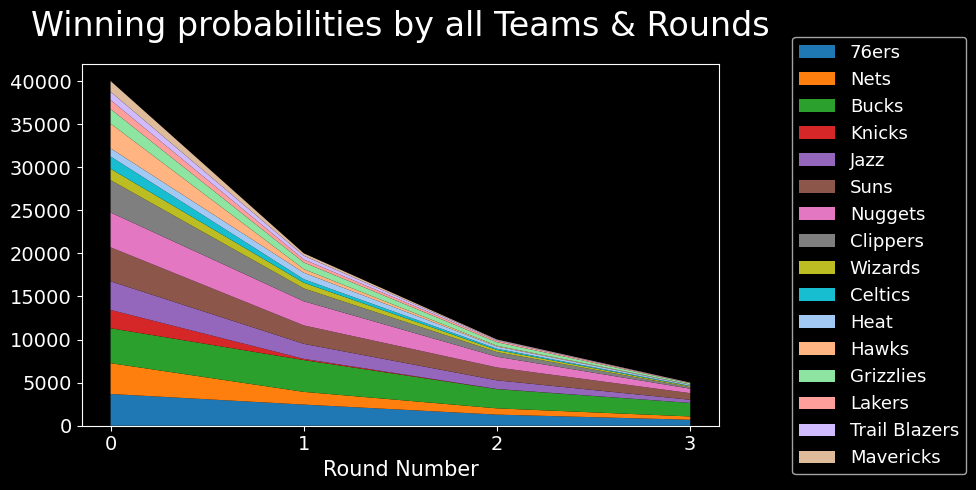

In [42]:
# check that a team's wins should get less and less in later rounds
fig = plotting(playoff.rounds)

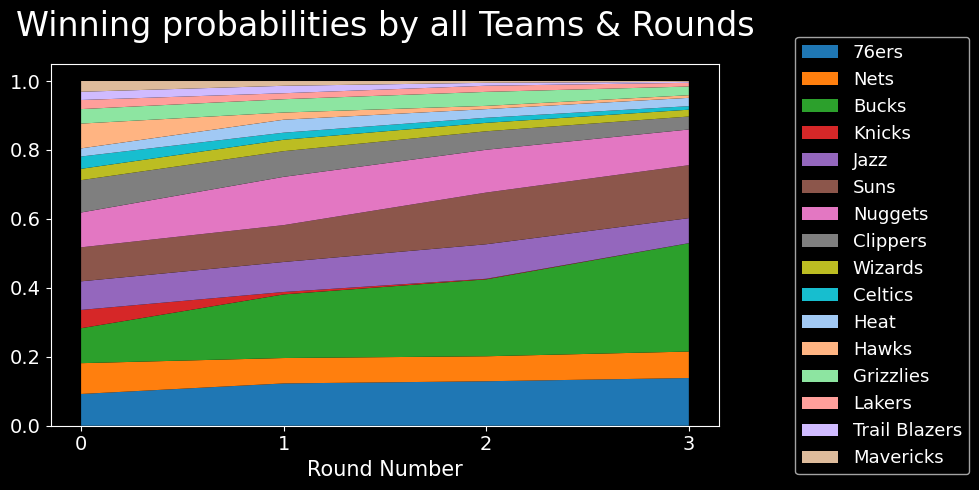

In [43]:
# plot the results: probabilities of winning for all teams at each round
fig = plotting(playoff.rounds_probs)